## *Exercise 3 - Music Genre Classification*

Συγγραφή: Χρήστος Νίκου

Αριθμός Μητρώου: 1115201800330

### Task 1 (Feed Forward Neural Network)

#### Step 1 (Dataloading of MFCCs)

We first begin by preparing the dataloading part for the MFCCs. For this purpose we create a utility `load_mfccs` function located in `utils.py`. The function takes as argument the type of the dataset to load which is either train, test or val. It returns the features of the corresponding dataset as well as the labels for the given dataset. Each one of the labels "classical", "pop", "rock", and "blues" are mapped to the integers 0, 1, 2, and 3, respectively. Furthermore, we create a Pytorch dataset object that inherits from `torch.utils.data.Dataset` in order to feed the data to our Neural Network. The class is defined in `utils.py` under the name `VectorDataset`.

In [1]:
import numpy as np
import torch

from utils import load_mfccs, VectorDataset
import matplotlib.pyplot as plt
from torch.utils.data import DataLoader
import torch.nn as nn
from sklearn.metrics import ConfusionMatrixDisplay
from torch.optim import SGD

Using the function `load_mfccs` we load the dataset of the mfccs corresponding for the training set.

In [ ]:
X, y = load_mfccs('train')

In [ ]:
print(X.shape, y.shape)
print(X.dtype)

We check the distribution of the classes for the training set.

In [ ]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.bar(range(4), np.bincount(y))
ax.set_title('Distribution of the samples for the training set')
plt.show()

As we can see the dataset is balanced since each class on the training set contains exactly 800 samples. Below we define the three dataloaders that will be used for training, one for the training set, one for the validation and one for the test set.

In [ ]:
X_train, y_train = load_mfccs(mode='train')
X_val, y_val = load_mfccs(mode='val')
X_test, y_test = load_mfccs(mode='test')

train_dloader = DataLoader(VectorDataset(X_train, y_train), batch_size=16, shuffle=True)
val_dloader = DataLoader(VectorDataset(X_val, y_val), batch_size=16, shuffle=True)
test_dloader = DataLoader(VectorDataset(X_test, y_test), batch_size=16, shuffle=False)

#### Step 2 (Defining a Fully connected Neural Network)

In the second step we define the first type of Neural Network that we will use to train and classify the samples using the features with the MFCCs. The first architecture is a Fully Connected Neural Network with 4 layers each one of them consisting of 26, 128, 32 and 4 neurons, respectively. The number 26 corresponds to the number of input features and the 4 is the number of classes (classical, hiphop, blues, rock_metal_hardrock). The architecture is located in `models.py` under the name `MLP`. Below you can see the architecture of this Neural Network.

In [ ]:
from models import MLP

In [ ]:
model = MLP()
model

#### Step 3 & 4 (Training loop & Validation loop)

In this step we create a custom function, named `training_loop` to handle the training of the Neural Network. The arguments of the function are the number of epochs, the optimizer to be used for training, the two dataloaders corresponding to the training/val sets, and the loss function to be used. The function is in `utils.py`.

Furthermore, we design a validation loop through the function `validation_loop` located in `utils.py`. The arguments of the function is the trained model, the test_dloader, and the loss function corresponding to the test samples. The function returns 

- (i) The average loss across all samples
- (ii) The average f1 macro
- (iii) The accuracy, and
- (iv) The confusion matrix corresponding to the classification.

#### Step 5 (Training the Feed Forward Neural Network)

In this step we train the Feed Forward Neural Network defined in Step 2. We use the utility function `training_loop` and we measure the training time on the CPU. Below we also define the number of epochs, the optimizer, the loss function and the learning rate to be used for training. Furthermore, we use the `validation_loop` to test the model's performance on the test set.

In [ ]:
EPOCHS = 30
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss()
optim = SGD(model.parameters(), lr=learning_rate)

In [ ]:
from utils import training_loop, validation_loop

In [ ]:
training_loop(EPOCHS, model, train_dloader, val_dloader, optim, loss_fn)

In [ ]:
loss, f1, acc, cm = validation_loop(model, test_dloader, loss_fn)

In [ ]:
print(f'Total loss: {loss:.3f}\nF1 score: {f1:.3f}\nAccuracy: {acc:.3f}')

In [ ]:
fig, ax = plt.subplots(figsize = (9, 7))
img = ConfusionMatrixDisplay(cm, display_labels=['classical', 'hiphop', 'rock_metal_hardrock', 'blues'])
img.plot(ax=ax)
ax.set_title('Confusion Matrix - Feed Forward Neural Network')
plt.show()

#### Step 6 (Training on GPU)

Now, we move the model on the GPU and we perform the same training as before and measure the time difference.

In [ ]:
# Check if gpu is available
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(torch.cuda.get_device_name())

In [ ]:
model = MLP()
model = model.to(device)
loss_fn = loss_fn.to(device)
optim = SGD(model.parameters(), lr=learning_rate)

In [ ]:
training_loop(
    epochs=EPOCHS,
    model=model,
    train_dloader=train_dloader,
    val_dloader=val_dloader,
    optim=optim,
    loss_fn=loss_fn,
    device=device
)


#### Step 7 (Choosing the best model)

In this step we train again the Feed Forward Neural Network and keep the model with the highest f1 score on the validation set. To implement this on code we add a boolean flag `keep_best` on the `training_loop`. When this flag is set to True then the model with the lowest f1 score on the validation set is stored in a `.pt` file. Below we see the results of this model too.

In [ ]:
model = MLP()
optim = SGD(model.parameters(), lr=learning_rate)
loss_fn = nn.CrossEntropyLoss()

In [ ]:
training_loop(
    epochs=EPOCHS,
    model=model,
    train_dloader=train_dloader,
    val_dloader=val_dloader,
    optim=optim,
    loss_fn=loss_fn,
    device='cpu',
    keep_best=True
)


In [ ]:
# Validating the best model
model = MLP()
model.load_state_dict(torch.load('model.pt', map_location=torch.device('cpu')))
loss, f1, acc, cm = validation_loop(model, test_dloader, loss_fn)

In [ ]:
print(f'-Total Loss: {loss:3f}\n- F1 score: {f1:.3f}\n- Accuracy: {acc:.3f}')

In [ ]:
fig, ax = plt.subplots(figsize = (9, 7))
img = ConfusionMatrixDisplay(cm, display_labels=['classical', 'hiphop', 'rock_metal_hardrock', 'blues'])
img.plot(ax=ax)
ax.set_title('Confusion Matrix - Feed Forward Neural Network (best model)')
plt.show()

### Task 2 (Convolutional Neural Network)

In the second part of this task we build a CNN and train it by using the melspectrogram representations of the audio segments. 

#### Step 1 (DataLoading and Visualizations)

As in the case of the Feed Forward Neural Network we define a utility function named `load_spectrograms` in order to parse the data corresponding to the mel-spectrogram representations. Below you can see the spectrograms for each genre from the training set.

In [2]:
from utils import load_spectrograms, INV_CLASS_MAPPING

In [3]:
X, y = load_spectrograms("train")

In [4]:
print(X.shape, y.shape)

(3200, 21, 128) (3200,)


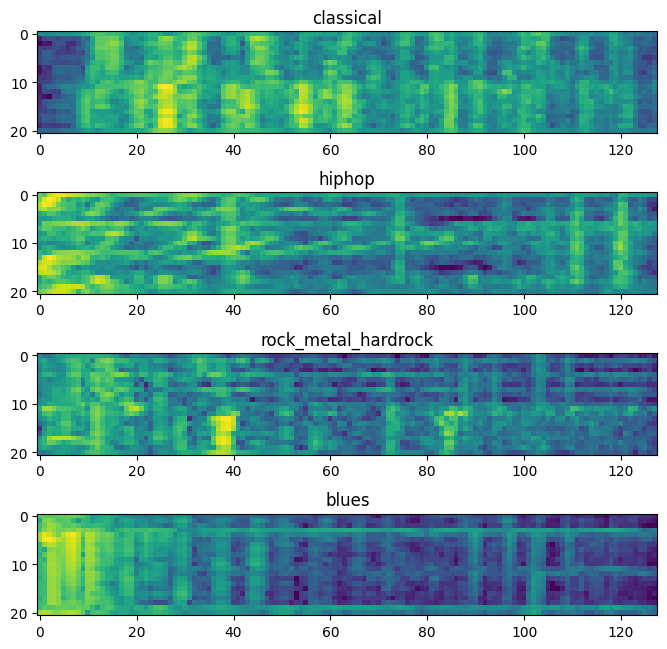

In [5]:
fig, ax = plt.subplots(figsize = (8, 8), nrows=4)

for i in range(4):
    idx = np.argwhere(y == i)[0].item()
    S = X[idx]
    ax[i].imshow(S)
    ax[i].set_title(INV_CLASS_MAPPING[i])

plt.show()

#### Step 2 (Defining the CNN architecture)

In this step we are asked to design a CNN consisting of:

1. Four convolutional layers with kernel size equal to 5 such that the sequence of channels is 1, 16, 32, 64, 128
2. The output of the last convolutional layer is the input to a fully connected neural network consisting of 5 layers with number of neurons: x (the dimension of the last convolutional layer), 1024, 256, 32, out_dim, where out_dim is the number of classes which is 4 in our case.

The architecture is defined in `models.py` under the class name `CNN`.

In [6]:
from models import CNN

device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = CNN(H=21, W=128).to(device)

#### Step 3 (Training the CNN - 1st Attempt)

For the training of the CNN we use the same function (`training_loop`) as in the case of the Feed Forward Neural Network. Furthermore, we define a new dataset class to handle the preprocessing step of the spectrograms to serve as input to the CNN.

In [ ]:
EPOCHS = 30
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss().to(device)
optim = SGD(model.parameters(), lr=learning_rate)

In [7]:
from utils import SpectrogramDataset

In [8]:
train_dloader = DataLoader(SpectrogramDataset(*load_spectrograms("train")), batch_size=16, shuffle=True)
val_dloader = DataLoader(SpectrogramDataset(*load_spectrograms("val")), batch_size=16, shuffle=True)
test_dloader = DataLoader(SpectrogramDataset(*load_spectrograms("test")), batch_size=16, shuffle=False)

In [ ]:
training_loop(
    epochs=EPOCHS,
    model=model,
    train_dloader=train_dloader,
    val_dloader=val_dloader,
    optim=optim,
    loss_fn=loss_fn,
    device=device,
    keep_best=True
)

As we can see from the previous graph the training loss but the validation loss constantly increases. This is a clear sign of overfitting. In the next step we add Max Pooling layers to our Network to overcome this problem. Below you can see that the results of the model on the test set are really low, indicating that the model has a poor generalization.

In [ ]:
# Validating the best model
model = CNN(H=21, W=128).to(device)
model.load_state_dict(torch.load('model.pt'))
loss, f1, acc, cm = validation_loop(model, test_dloader, loss_fn, device=device)

In [ ]:
print(f'-Total Loss: {loss:3f}\n- F1 score: {f1:.3f}\n- Accuracy: {acc:.3f}')

In [ ]:
fig, ax = plt.subplots(figsize = (9, 7))
img = ConfusionMatrixDisplay(cm, display_labels=['classical', 'hiphop', 'rock_metal_hardrock', 'blues'])
img.plot(ax=ax)
ax.set_title('Confusion Matrix - CNN (No Max Pooling)')
plt.show()

#### Step 4 (Pooling and Padding)

In this Step we add Max Pooling layers on the CNN architecture. There are many benefits of pooling operations:

1. Spatial down-sampling: Pooling operations, such as max pooling or average pooling, reduce the size of the feature maps. This downsampling reduces the computational complexity and memory requirements of subsequent layers in the network. By reducing the spatial dimensions, the model becomes more computationally efficient.

2. Translation invariance: Pooling helps to achieve some degree of translation invariance in the learned features. By summarizing the local information in a pooled representation, the network becomes less sensitive to small spatial variations in the input. This allows the network to recognize the same pattern or object regardless of its exact location in the input.

3. Feature extraction: Pooling operations help to capture the most salient features of the input. By performing operations like max pooling, which retains the maximum value within each pooling region, the network focuses on the most activated features, discarding less relevant information. This can improve the network's ability to detect important patterns and make the learned representations more robust.

4. Dimensionality reduction: Pooling reduces the number of parameters and computations required in the network, which can help prevent overfitting and improve generalization. By reducing the spatial dimensions, the number of parameters in subsequent layers is reduced, making the network less prone to overfitting and improving its ability to generalize well to new, unseen data.

To implement the Max Pooling in our code, we add a boolean flag `pooling` in the constructor of the CNN class. When this flag is set to True then after each convolution a Max pooling with kernel size equal to 2 and padding equal to 2 is used.

In [ ]:
model = CNN(H=21, W=128, pooling=True).to(device)

In [ ]:
EPOCHS = 30
learning_rate = 1e-3
loss_fn = nn.CrossEntropyLoss().to(device)
optim = SGD(model.parameters(), lr=learning_rate)

In [ ]:
training_loop(
    epochs=EPOCHS,
    model=model,
    train_dloader=train_dloader,
    val_dloader=val_dloader,
    optim=optim,
    loss_fn=loss_fn,
    device=device,
    keep_best=True
)

In [ ]:
# Validating the best model
model = CNN(H=21, W=128, pooling=True).to(device)
model.load_state_dict(torch.load('model.pt'))
loss, f1, acc, cm = validation_loop(model, test_dloader, loss_fn, device=device)

In [ ]:
print(f'-Total Loss: {loss:3f}\n- F1 score: {f1:.3f}\n- Accuracy: {acc:.3f}')

In [ ]:
fig, ax = plt.subplots(figsize = (9, 7))
img = ConfusionMatrixDisplay(cm, display_labels=['classical', 'hiphop', 'rock_metal_hardrock', 'blues'])
img.plot(ax=ax)
ax.set_title('Confusion Matrix - CNN (Max Pooling)')
plt.show()

#### Step 5 (Optimizers)

In this Step we try different optimizers and see the one that achieves the best generalization.

In [12]:
from torch.optim import Adam, SGD, Adagrad, RMSprop
import pandas as pd
from utils import train_and_validate

In [10]:
optims = [(Adam, 'Adam'), (SGD, 'SGD'), (Adagrad, 'Adagrad'), (RMSprop, 'RMSprop')]

In [13]:
EPOCHS = 30
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
loss_fn = nn.CrossEntropyLoss().to(device)

In [15]:
f1s, accs, losses, names = [], [], [], []
for optim, name in optims:
    model = CNN(H=21, W=128, pooling=True).to(device)
    op = optim(model.parameters(), lr=learning_rate)
    loss, f1, acc, _ = train_and_validate(
        model=model,
        epochs=EPOCHS,
        train_dloader=train_dloader,
        val_dloader=val_dloader,
        test_dloader=test_dloader,
        optim=op,
        loss_fn=loss_fn,
        device=device
    )
    names.append(name)
    f1s.append(f1)
    losses.append(loss)
    accs.append(acc)

In [18]:
results = pd.DataFrame({
    'F1 score': f1s,
    'Accuracy': accs,
    'Loss': losses
}, index=names).sort_values(by=['F1 score'], ascending=False)
results

,F1 score,Accuracy,Loss
SGD,0.681271,0.678779,0.878719
Adagrad,0.665522,0.656977,0.873810
Adam,0.642118,0.635901,1.156430
RMSprop,0.626840,0.636628,3.164322
